### EDA 2019

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
spark = SparkSession.builder.appName('2019-EDA').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [12]:
df_2019 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/2019", inferSchema=True, header=True)


In [13]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_2019.rdd.getNumPartitions()

displaypartitions(df_2019)

Partitions: 150


+-----------+------+
|partitionId| count|
+-----------+------+
|        149|441790|
|         45|499109|
|         22|500561|
|        122|501059|
|         71|501394|
|         40|501504|
|        101|501636|
|         31|501739|
|         10|501790|
|         27|501791|
|         44|501848|
|         13|501891|
|         75|502174|
|         58|502222|
|         14|502574|
|        126|502812|
|         26|502822|
|         54|502838|
|         30|502855|
|        118|502864|
|        143|502958|
|         62|503041|
|         36|503089|
|          6|503100|
|         18|503407|
|         35|503509|
|         88|503676|
|         92|503745|
|        131|504327|
|         83|504368|
|         17|504404|
|        110|504453|
|        134|504488|
|        130|504490|
|        135|504581|
|         57|504584|
|          5|504652|
|         80|504694|
|         53|504707|
|         49|504711|
|         79|504728|
|          9|504758|
|        139|504763|
|         84|504812|
|        105|

In [14]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
# don't run for loops on the data, running for loops on the columns is fine, doing it on the entire data can cause problems. 
df_2019.select([count(when(df_2019[c].isNull(), c)).alias(c) for c in df_2019.columns]).show()

+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|Trip ID|Trip Start Timestamp|Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|Fare|Tip|Additional Charges|Trip Total|Shared Trip Authorized|Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------

<AxesSubplot:>

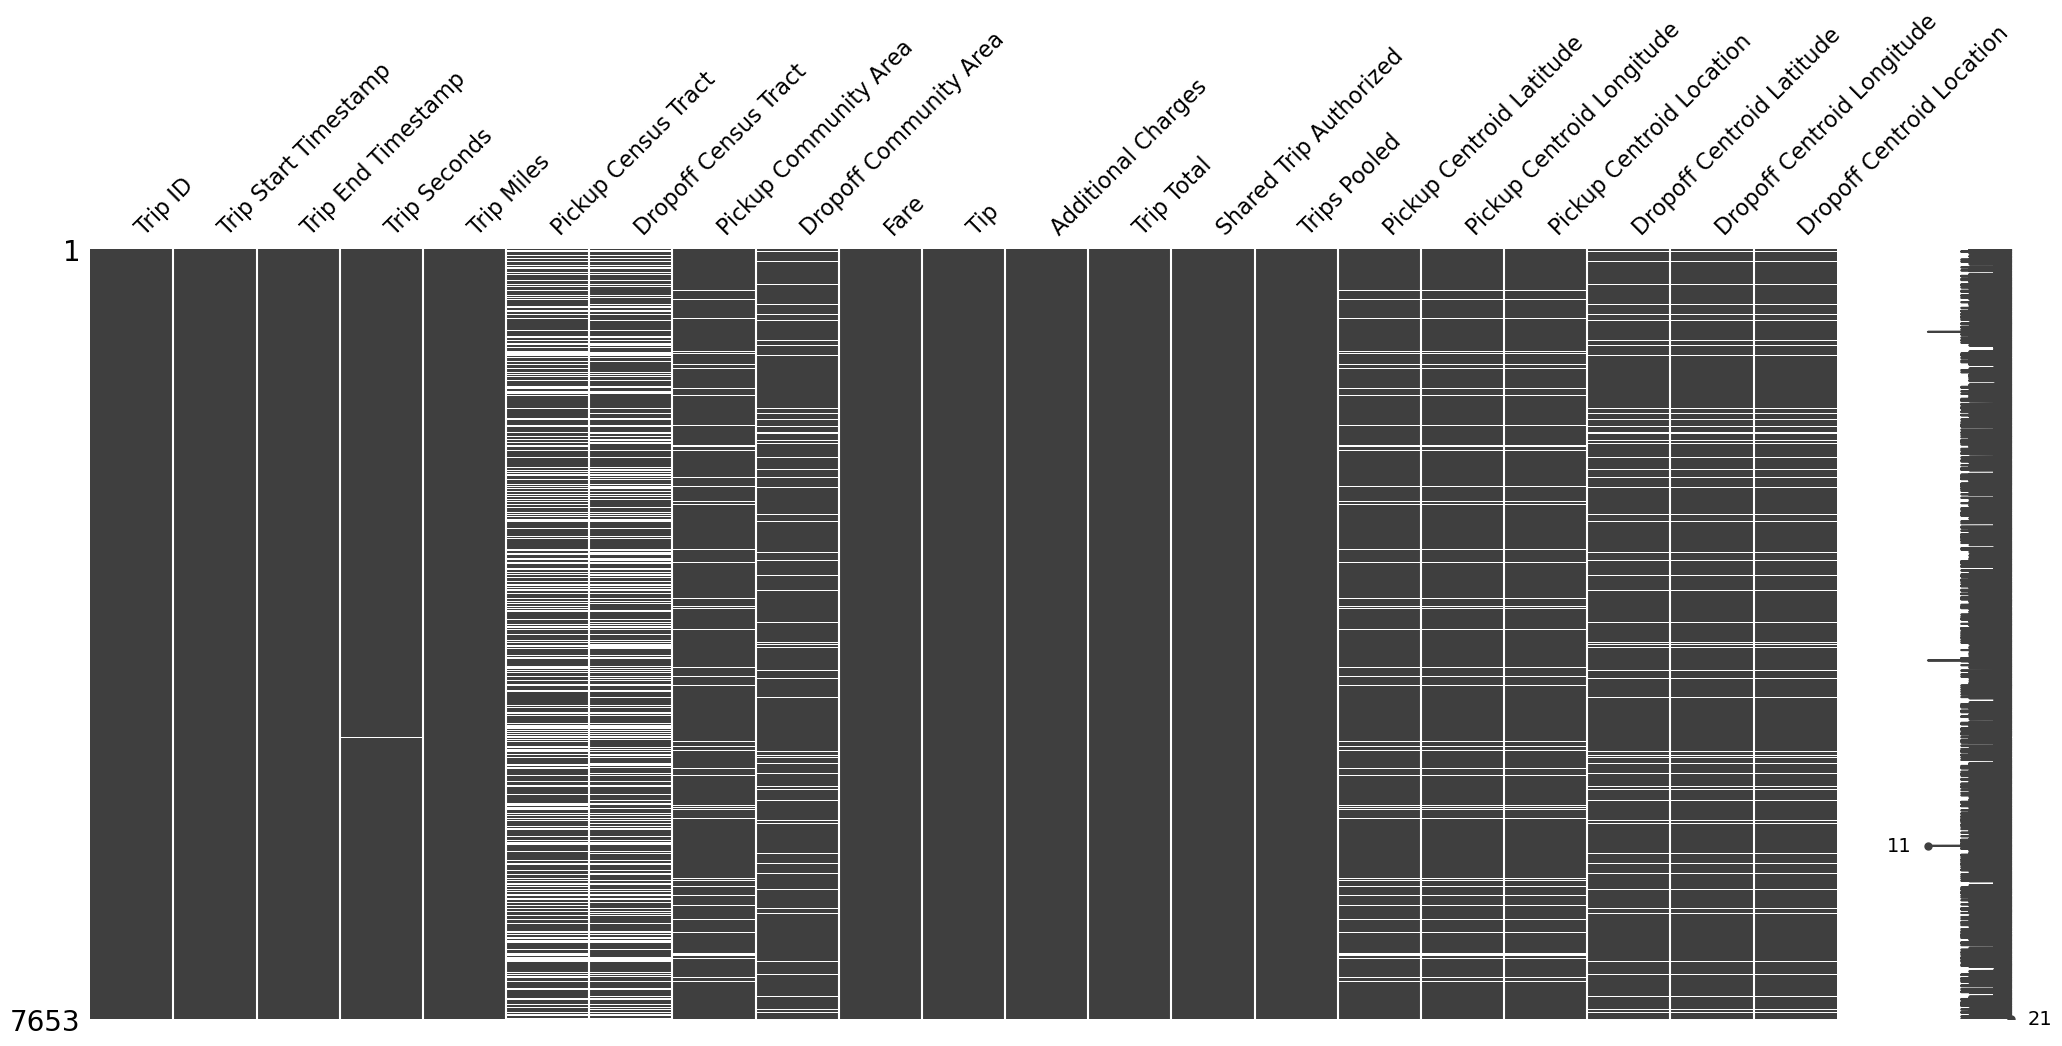

In [15]:
import missingno as msno
%matplotlib inline
msno.matrix(df_2019.sample(fraction=1/10000).toPandas())

In [ ]:
#Approximate number of 2021 trips
from pyspark.sql.functions import approxCountDistinct

df_2019.select(approxCountDistinct("Trip ID", rsd = 0.01)).show()

23/11/16 01:50:58 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
df_2019 = df_2019.dropna(how='any')
df_2019 = df_2019.dropDuplicates()

In [ ]:
# Convert 'Trip start timestamp' and 'Trip End Timestamp' columns to timestamp
df_2019 = df_2019.withColumn("Trip Start Timestamp", F.to_timestamp(F.col("Trip Start Timestamp"), "MM/dd/yyyy hh:mm:ss a"))
df_2019 = df_2019.withColumn("Trip End Timestamp", F.to_timestamp(F.col("Trip End Timestamp"), "MM/dd/yyyy hh:mm:ss a"))

In [ ]:
df_2019 = df_2019.drop('Trips Pooled','Additional Charges','Shared Trip Authorized', "Tip")
df_2019 = df_2019.withColumnRenamed("Trip ID","ID").withColumnRenamed("Trip Start Timestamp","start_timestamp").withColumnRenamed("Trip End Timestamp","end_timestamp").withColumnRenamed("Trip Miles",\
                "miles").withColumnRenamed("Pickup Census Tract","pickup_tract").withColumnRenamed("Dropoff Census Tract","dropoff_tract").withColumnRenamed("Pickup Community Area","pickup_area"\
                ).withColumnRenamed("Dropoff Community Area","dropoff_area").withColumnRenamed("Trip Total","total").withColumnRenamed("Pickup Centroid Latitude","pickup_lat").withColumnRenamed(\
                "Pickup Centroid Longitude","pickup_lon").withColumnRenamed("Pickup Centroid Location","pickup_location").withColumnRenamed("Dropoff Centroid Latitude","dropoff_lat").withColumnRenamed(\
                "Dropoff Centroid Longitude","dropoff_lon").withColumnRenamed("Dropoff Centroid Latitude", "dropoff_lat").withColumnRenamed("Trip Seconds", "trip_seconds").withColumnRenamed("Dropoff Centroid Location", "dropoff_location").withColumnRenamed("Fare", "fare")

In [ ]:
df_2019 = df_2019.withColumn('date_only', F.to_date(df_2019.end_timestamp))
# add the month column
df_2019 = df_2019.withColumn('month', F.month(df_2019.start_timestamp))
df_2019 = df_2019.withColumn('hour', F.hour(df_2019.start_timestamp))

In [ ]:
# get rides that occurred within hyde park
# add kenwood and woodlawn to this list - only if the other location is hyde park                    
df_hp = df_2019.filter((df_2019.pickup_area == 41) & (df_2019.dropoff_area == 41))
df_kw = df_2019.filter(((df_2019.pickup_area == 41) & (df_2019.dropoff_area == 42)) | ((df_2019.pickup_area == 42) & (df_2019.dropoff_area == 41)))
df_wl = df_2019.filter(((df_2019.pickup_area == 41) & (df_2019.dropoff_area == 39)) | ((df_2019.pickup_area == 39) & (df_2019.dropoff_area == 41)))
df_area = df_hp.union(df_kw).union(df_wl)

In [ ]:
df_area.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas().plot(x="month",y="count(ID)")

In [ ]:
# rides per hour:
rides_per_hour = df_area.groupBy("hour").count().orderBy("hour")

# Convert the result to Pandas for local plotting
rides_per_hour_pd = rides_per_hour.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(rides_per_hour_pd["hour"], rides_per_hour_pd["count"], color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.title("Number of Rides Per Hour")
plt.show()

In [ ]:
df_area_program = df_area.filter((df_area.fare <= 15.0) & ((df_area.hour >= 17) | (df_area.hour < 4)))

In [ ]:
import seaborn as sns

df_area_program_pd = df_area_program.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_area_program_pd['hour'], bins=24, kde=False, color='skyblue')
plt.title('Distribution of Pickup Hours for Filtered Rides')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()


In [ ]:
# storing data on the bucket
df_area_program.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2019.csv")
df_2019.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2019.csv")